# Start working on a standalone autoencoder class

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class PreConvBlock(nn.Module):
    def __init__(self, 
                 in_channels = 1, 
                 out_channels = 16, 
                 kernel = 3, 
                 stride=1, 
                 pool_size = 2,
                 use_batch_norm = False):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Stride for the convolutional layers.
        """
        super(PreConvBlock, self).__init__()
        
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, 
                      kernel_size=kernel, stride=stride, 
                      padding=(kernel - stride) // 2, 
                      bias= not use_batch_norm),
        ])
        if use_batch_norm:
            self.layers.append(nn.BatchNorm2d(out_channels))
        
        self.layers.append(nn.ReLU(inplace=True))
        self.layers.append(nn.MaxPool2d(kernel_size=pool_size))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
class ResidualBlock(nn.Module):
    def __init__(self, 
                 n_channels = 16, 
                 kernel = 3, 
                 stride = 1, 
                 use_batch_norm = False, 
                 downsample=None,
                 pool_size = 4,
                 n_layers = 3):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Stride for the convolutional layers.
            downsample (nn.Module, optional): Downsampling layer if input and output dimensions differ.
        """
        super(ResidualBlock, self).__init__()
        
        self.layers = nn.ModuleList()
        for i_layer in range(n_layers):
            self.layers.append(nn.Conv2d(n_channels, n_channels, 
                                          kernel_size=kernel, stride=stride, 
                                          padding=(kernel - stride) // 2, 
                                          bias= not use_batch_norm))
            if use_batch_norm:
                self.layers.append(nn.BatchNorm2d(n_channels))
            if i_layer!=(n_layers - 1):
                self.layers.append(nn.ReLU(inplace=True))
        
        self.downsample = downsample  # Optional downsampling layer
        self.post_residual_layers = nn.ModuleList([nn.ReLU(inplace=True)])
        if pool_size is not None:
            self.post_residual_layers.append(nn.MaxPool2d(kernel_size=pool_size))
    
    def forward(self, x):
        identity = x

        # Pass through the layers in the ModuleList
        for layer in self.layers:
            x = layer(x)

        # Apply downsampling to the identity if necessary
        if self.downsample:
            identity = self.downsample(identity)

        # Add the residual connection
        x += identity
        for layer in self.post_residual_layers:
            x = layer(x)

        return x
    
class Encoder(nn.Module):

    def __init__(self, 
                 configs):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Stride for the convolutional layers.
        """
        super(Encoder, self).__init__()
        
        self.configs = configs

        self.residual_layers = nn.ModuleList()

        for i_blocks in range(configs['num_blocks']):
            self.residual_layers.append(PreConvBlock(configs['in_channels_%d'%i_blocks],
                                            configs['out_channels_%d'%i_blocks],
                                            configs['kernel_preconv'],
                                            configs['stride_preconv'],
                                            configs['pool_size_preconv_%d'%i_blocks],
                                            configs['use_batch_norm_preconv']))
            self.residual_layers.append(ResidualBlock(configs['out_channels_%d'%i_blocks],
                                             configs['kernel_residual'],
                                             configs['stride_residual'],
                                             configs['use_batch_norm_residual'],
                                             pool_size=configs['pool_size_residual_%d'%i_blocks],
                                             n_layers=configs['n_layers_residual']))
            
        self.linear_layers = nn.ModuleList([nn.Linear(configs['out_conv'], configs['out_linear'], bias = not configs['use_batch_norm_linear']),])
        if configs['use_batch_norm_linear']:
            self.linear_layers.append(nn.BatchNorm1d(configs['out_linear']))
        self.linear_layers.append(nn.ReLU(inplace=True))
        self.linear_layers.append(nn.Linear(configs['out_linear'], configs['embed_size']))

    def forward(self, x):
        bs, seq_length, c, h ,w = x.size()
        
        x = x.view(bs*seq_length, c, h, w)
        for layer in self.residual_layers:
            x = layer(x)
        
        x = x.view(bs*seq_length, -1)
        for layer in self.linear_layers:
            x = layer(x)
        
        x = x.view(bs, seq_length, -1)
        return x

In [3]:
class SingleSessionDecoder(nn.Module):
    def __init__(self, configs):
        super(SingleSessionDecoder, self).__init__()
        self.configs = configs
        self.linear_layer = nn.Linear(configs['embed_size'], configs['image_height']*configs['image_width'])

    def forward(self, x):
        bs, seq_length, _ = x.size()
        x = self.linear_layer(x)
        x = x.view(bs, seq_length, 1, self.configs['image_height'], self.configs['image_width'])
        return x

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, configs):
        super(AutoEncoder, self).__init__()
        self.configs = configs
        self.encoder = Encoder(configs)
        self.decoder = SingleSessionDecoder(configs)
    
    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x, z

In [5]:
configs = {
    'num_blocks': 2,
    'in_channels_0': 1,
    'out_channels_0': 16,
    'in_channels_1': 16,
    'out_channels_1': 32,
    'kernel_preconv': 3,
    'stride_preconv': 1,
    'pool_size_preconv_0': 2,
    'pool_size_preconv_1': 4,
    'use_batch_norm_preconv': False,
    'kernel_residual': 3,
    'stride_residual': 1,
    'use_batch_norm_residual': False,
    'pool_size_residual_0': None,
    'pool_size_residual_1': 4,
    'n_layers_residual': 3,
    'out_conv': 288,
    'out_linear': 128,
    'embed_size': 16,
    'use_batch_norm_linear': False,
    'image_height': 120,
    'image_width': 112
}

In [6]:
AE = AutoEncoder(configs)

In [7]:
AE

AutoEncoder(
  (encoder): Encoder(
    (residual_layers): ModuleList(
      (0): PreConvBlock(
        (layers): ModuleList(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (1): ResidualBlock(
        (layers): ModuleList(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
          (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (post_residual_layers): ModuleList(
          (0): ReLU(inplace=True)
        )
      )
      (2): PreConvBlock(
        (layers): ModuleList(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          

In [59]:
import cv2

def process_image(
    image,
    target_shape,
    *,
    transpose=False,
    remove_info = None,
    toy_mode=False
    ):
    """Given an image, process it and return the array."""
    # Load the image.
    h, w, c = target_shape
    x = cv2.imread(image,0)
    # x = mpimg.imread(image)[:,:,0]
    if x is None:
        print(image)
    if transpose:
        x = np.transpose(x,(1,0))
    h_origin, w_origin = x.shape
    if remove_info is not None:
        coord, mean, mode = remove_info['coord'], remove_info['mean'], remove_info['mode']
        if mode == 'crop':
            x = x[int(coord[0]/h*h_origin+0.5):]
        elif mode == 'block':
            x[:int(coord[0]/h*h_origin+0.5)] = x.max()
            assert toy_mode
        else:
            assert False
    if (x.shape[0] != h) or (x.shape[1] != w):
        x = cv2.resize(x,(w,h))
    x = (x / 255.).astype(np.float32)
    return x

In [77]:
img = process_image(image= '/data5/zwang71/MiceBehavior/data/SC/frames/side/SC065/20210506/SC-SC065-20210506-19/SC-SC065-20210506-19-side-01094.jpg',
              target_shape=(120,112,1),
              remove_info= {'mode': 'crop', 'coord': [26,20],'mean': None },)

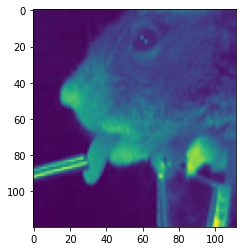

In [78]:
plt.imshow(img)

(5, 120, 112)


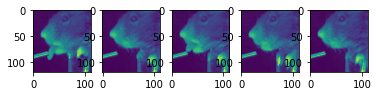

In [105]:
inds = ['01094','00195','01200','01120','01900']
example_images = []
for i,indstr in enumerate(inds):
    img = process_image(image= '/data5/zwang71/MiceBehavior/data/SC/frames/side/SC065/20210506/SC-SC065-20210506-19/SC-SC065-20210506-19-side-%s.jpg'%indstr,
              target_shape=(120,112,1),
              remove_info= {'mode': 'crop', 'coord': [26,20],'mean': None },)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    example_images.append(img)

example_images = np.array(example_images)
print(example_images.shape)
np.save('/mnt/fs6/zwang71/BehaviorVideo/rewrite_autoencoder/example_images.npy',example_images)

    

In [8]:
example_images = np.load('example_images.npy')

In [9]:
AE = AutoEncoder(configs)
optimizer = torch.optim.Adam(AE.parameters(), lr=1e-3)

loss_fn = nn.MSELoss()

n_epochs = 1000

for epoch in range(n_epochs):
    optimizer.zero_grad()
    x_hat, z = AE.forward(torch.tensor(example_images).float().view(5,1,1,120,112))
    loss = loss_fn(x_hat.squeeze(), torch.tensor(example_images).float())
    loss.backward()
    optimizer.step()
    if epoch%100 == 99: print(epoch, loss.item())

99 0.005740813445299864
199 0.0046881092712283134
299 0.004562122281640768
399 0.003842707024887204
499 0.0026612388901412487
599 0.0020637435372918844
699 0.0018116998253390193
799 0.0015885968459770083
899 0.0012940552551299334
999 0.000968906213529408


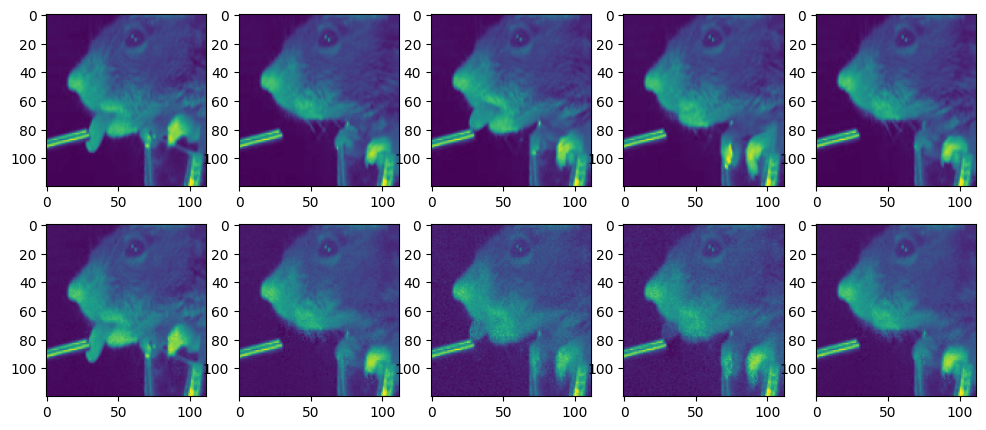

In [10]:
with torch.no_grad():
    img_hat, z = AE.forward(torch.tensor(example_images).float().view(5,1,1,120,112))
plt.subplots(2,5,figsize=(12,5))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(example_images[i])
    plt.subplot(2,5,i+6)
    plt.imshow(img_hat.squeeze().detach().numpy()[i])

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [15]:
# Check for GPU availability and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate your AutoEncoder and move it to the device
AE = AutoEncoder(configs).to(device)
optimizer = torch.optim.Adam(AE.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

n_epochs = 20000

for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Convert example_images to tensor, reshape it, and move to the device
    inputs = torch.tensor(example_images).float().view(5, 1, 1, 120, 112).to(device)
    
    # Forward pass
    x_hat, z = AE(inputs)
    
    # Prepare the target tensor and move to the device
    target = torch.tensor(example_images).float().to(device)
    
    # Compute loss, backpropagate, and update the model parameters
    loss = loss_fn(x_hat.squeeze(), target)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 99:
        print(epoch, loss.item())


Using device: cuda
99 0.005734231788665056
199 0.004689202178269625
299 0.004594057332724333
399 0.004010921809822321
499 0.002859947970137
599 0.0021521709859371185
699 0.0018239713972434402
799 0.0015222580404952168
899 0.0011193298269063234
999 0.0007637295639142394
1099 0.000454570516012609
1199 0.0002993868838530034
1299 0.00021666551765520126
1399 0.00017327716341242194
1499 0.00014958497195038944
1599 0.00013677698734682053
1699 0.00012990087270736694
1799 0.00012484510079957545
1899 0.00012158211757196113
1999 0.00012040245928801596
2099 0.00011554264347068965
2199 0.00011137594265164807
2299 0.00010623023990774527
2399 9.856906399363652e-05
2499 8.94591721589677e-05
2599 8.53426827234216e-05
2699 6.72389505780302e-05
2799 5.696490916307084e-05
2899 4.492617881624028e-05
2999 3.5466935514705256e-05
3099 2.762601616268512e-05
3199 2.1560537788900547e-05
3299 1.6166015484486707e-05
3399 1.2224436432006769e-05
3499 9.216530997946393e-06
3599 6.916689471836435e-06
3699 5.1767747208

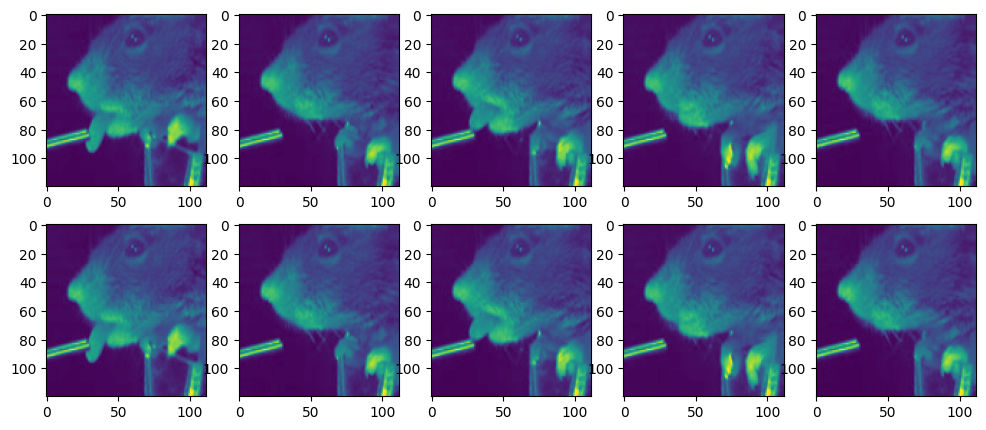

In [18]:
with torch.no_grad():
    img_hat, z = AE.forward(torch.tensor(example_images).float().view(5,1,1,120,112).to(device))
plt.subplots(2,5,figsize=(12,5))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(example_images[i])
    plt.subplot(2,5,i+6)
    plt.imshow(img_hat.cpu().squeeze().detach().numpy()[i])